<a href="https://colab.research.google.com/github/seymadogru/BasicDataTypes/blob/master/Warehouse_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import gym
from gym import spaces
import numpy as np
import time
from IPython.display import clear_output

class GuidedShiftLogisticsEnv(gym.Env):
    def __init__(self):
        super(GuidedShiftLogisticsEnv, self).__init__()

        self.grid_size = 15
        self.map = np.zeros((self.grid_size, self.grid_size), dtype=int)

        self._generate_map()

        self.action_space = spaces.Discrete(5)

        # Gözlem: [X, Y, Slot1, Slot2, Batarya, VARDİYA]
        low = np.array([0, 0, 0, 0, 0, 0])
        high = np.array([self.grid_size, self.grid_size, 5, 5, 11, 3])
        self.observation_space = spaces.Box(low, high, dtype=np.int32)

        self.agent_pos = [0, 0]
        self.slots = [0, 0]
        self.battery = 100.0
        self.order_list = []
        self.shift_status = 0
        self.max_steps = 800 # Adım sınırını artırdık
        self.current_step = 0

    def _generate_map(self):
        self.map.fill(0)
        self.map[0, 0] = 2 # DOCK
        self.map[14, 0] = 9 # ŞARJ

        # Duvarlar (Biraz azalttım ki çok sıkışmasın)
        for _ in range(30):
            x, y = np.random.randint(1, 14, 2)
            if (x,y) != (14,0): self.map[x, y] = 1

        self.shelves = {
            1: [14, 14], 2: [0, 14], 3: [14, 5], 4: [7, 7]
        }
        for k, pos in self.shelves.items():
            self.map[pos[0], pos[1]] = 10 + (k-1)

    def reset(self):
        self.agent_pos = [0, 0]
        self.slots = [0, 0]
        self.battery = 100.0
        self.shift_status = 0
        self.current_step = 0
        self.order_list = list(np.random.choice([1, 2, 3, 4], 6))
        return self._get_obs()

    def _get_obs(self):
        return np.array([
            self.agent_pos[0], self.agent_pos[1],
            self.slots[0], self.slots[1],
            int(self.battery/10), self.shift_status
        ])

    def _dist(self, pos1, pos2):
        # Manhattan Mesafesi (Kare kare mesafe)
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def step(self, action):
        self.current_step += 1
        reward = -0.1 # Standart adım cezası (Düşürdük ki hareketten korkmasın)
        done = False

        prev_pos = self.agent_pos.copy()

        # Enerji
        carried_count = (1 if self.slots[0] > 0 else 0) + (1 if self.slots[1] > 0 else 0)
        self.battery -= (0.2 + carried_count * 0.1)

        if self.battery <= 0:
            return self._get_obs(), -100, True, {}

        # Hareket
        if action == 0: self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1: self.agent_pos[0] = min(self.grid_size - 1, self.agent_pos[0] + 1)
        elif action == 2: self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3: self.agent_pos[1] = min(self.grid_size - 1, self.agent_pos[1] + 1)

        # Duvar
        if self.map[self.agent_pos[0], self.agent_pos[1]] == 1:
            reward -= 2 # Duvar cezasını düşürdük
            self.agent_pos = prev_pos

        # Vardiya Durumu Güncelleme
        if len(self.order_list) == 0 and sum(self.slots) == 0 and self.shift_status == 0:
            self.shift_status = 1

        curr_cell = self.map[self.agent_pos[0], self.agent_pos[1]]

        # --- YENİ: HEDEFE YAKLAŞMA ÖDÜLÜ (Distance Heuristic) ---
        target_pos = None

        # Hedef Belirleme Mantığı
        if self.shift_status == 1: # Şarja Git
            target_pos = [14, 0]
        elif self.shift_status == 2: # Eve Dön
            target_pos = [0, 0]
        elif self.shift_status == 0: # Çalışıyor
            if sum(self.slots) > 0: # Elinde yük var -> Rafa Git
                # İlk dolu slotun rafına git
                item = self.slots[0] if self.slots[0] > 0 else self.slots[1]
                target_pos = self.shelves[item]
            elif len(self.order_list) > 0: # Yük yok -> Dock'a git mal al
                target_pos = [0, 0]
            elif self.battery < 30: # Acil Şarj
                target_pos = [14, 0]

        # Eğer bir hedef varsa ve hareket ettiysek mesafeyi kontrol et
        if target_pos:
            dist_old = self._dist(prev_pos, target_pos)
            dist_new = self._dist(self.agent_pos, target_pos)

            if dist_new < dist_old:
                reward += 0.2 # Sıcak! (Yaklaştın)
            elif dist_new > dist_old:
                reward -= 0.1 # Soğuk! (Uzaklaştın)

        # --- ETKİLEŞİMLER ---
        if action == 4:
            if curr_cell == 9: # Şarj
                if self.shift_status == 1:
                    self.battery = 100.0; self.shift_status = 2; reward += 50
                elif self.shift_status == 0 and self.battery < 50:
                    self.battery = 80.0; reward += 20
                else: reward -= 5

            elif curr_cell == 2: # Dock
                if self.shift_status == 2:
                    reward += 500; done = True
                elif self.shift_status == 0:
                    if 0 in self.slots and len(self.order_list) > 0:
                        empty_idx = self.slots.index(0)
                        self.slots[empty_idx] = self.order_list.pop(0)
                        reward += 30
                    else: reward -= 5

            elif curr_cell >= 10 and self.shift_status == 0: # Raf
                shelf_type = curr_cell - 10 + 1
                delivered = False
                for i in range(2):
                    if self.slots[i] == shelf_type:
                        self.slots[i] = 0; reward += 80; delivered = True; break
                if not delivered: reward -= 5
            else:
                reward -= 2

        if self.current_step >= self.max_steps: done = True

        return self._get_obs(), reward, done, {}

    def render(self):
        # (Render fonksiyonu aynı kalabilir veya görseli sadeleştirebiliriz)
        # Önceki render kodunu buraya kopyalayabilirsin, logic değişmedi.
        # Yer kazanmak için buraya tekrar yazmıyorum, üstteki kodun aynısı.
        pass

    # Render'ı tekrar yazayım ki eksik kalmasın:
    def render(self):
        print(f"\n--- GÜDÜMLÜ LOJİSTİK (15x15) ---")
        st_msg = ["ÇALIŞIYOR", "ŞARJA GİDİYOR", "EVE DÖNÜYOR"][self.shift_status]
        print(f"MOD: {st_msg} | Adım: {self.current_step}")

        d_bat = int(self.battery)
        col = "🟢" if d_bat > 30 else "🔴"
        print(f"PİL: {col} %{d_bat}")
        s1 = chr(64+self.slots[0]) if self.slots[0]>0 else "-"
        s2 = chr(64+self.slots[1]) if self.slots[1]>0 else "-"
        print(f"YÜK: [{s1}][{s2}] | Kalan İş: {len(self.order_list)}")

        for x in range(self.grid_size):
            row = ""
            for y in range(self.grid_size):
                cell = self.map[x, y]
                if x==self.agent_pos[0] and y==self.agent_pos[1]: row+="🤖"
                elif cell==1: row+="🧱"
                elif cell==2: row+="🏠"
                elif cell==9: row+="⚡"
                elif cell>=10: row+=chr(55+cell)+" "
                else: row+=". "
            print(row)

In [6]:
import matplotlib.pyplot as plt

env = GuidedShiftLogisticsEnv()
q_table = {}

# PARAMETRE GÜNCELLEMESİ
alpha = 0.2       # Daha hızlı öğrensin (Eskisi 0.1 idi)
gamma = 0.99      # Geleceğe önem versin
epsilon = 1.0
epsilon_decay = 0.9998 # Yavaş yavaş azaltsın
min_epsilon = 0.05 # Daima %5 keşfetme payı kalsın (Takılmayı önler)

def get_state_key(obs):
    return tuple(obs)

history_rewards = []
print("Güdümlü Eğitim Başlıyor... (Robot artık kokuyu takip edecek)")

episodes = 40000
for episode in range(episodes):
    obs = env.reset()
    state = get_state_key(obs)
    done = False
    total_reward = 0

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
            action = np.argmax(q_table[state])

        next_obs, reward, done, _ = env.step(action)
        next_state = get_state_key(next_obs)

        if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
        if next_state not in q_table: q_table[next_state] = np.zeros(env.action_space.n)

        old_value = q_table[state][action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state][action] = new_value

        state = next_state
        total_reward += reward

    history_rewards.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if episode % 5000 == 0:
        print(f"Episode: {episode} | Puan: {total_reward:.1f} | Epsilon: {epsilon:.3f}")

print("✅ Eğitim Tamamlandı!")

Güdümlü Eğitim Başlıyor... (Robot artık kokuyu takip edecek)
Episode: 0 | Puan: -210.8 | Epsilon: 1.000
Episode: 5000 | Puan: -81.7 | Epsilon: 0.368
Episode: 10000 | Puan: -48.1 | Epsilon: 0.135
Episode: 15000 | Puan: 99.6 | Epsilon: 0.050
Episode: 20000 | Puan: 293.1 | Epsilon: 0.050
Episode: 25000 | Puan: -77.9 | Epsilon: 0.050
Episode: 30000 | Puan: 15.2 | Epsilon: 0.050
Episode: 35000 | Puan: -26.5 | Epsilon: 0.050
✅ Eğitim Tamamlandı!


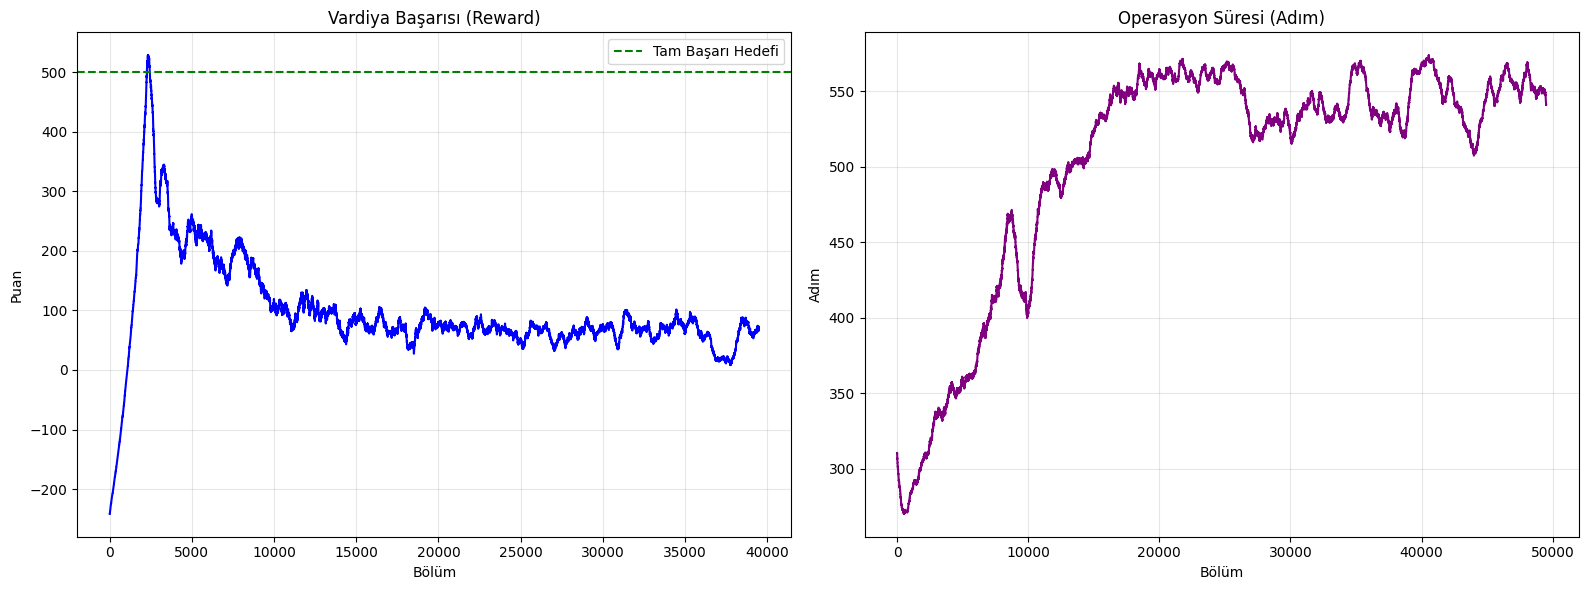

In [7]:
def moving_average(data, window_size=500):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(16, 6))

# Ödül Grafiği
plt.subplot(1, 2, 1)
plt.plot(moving_average(history_rewards), color='blue', linewidth=1.5)
plt.title("Vardiya Başarısı (Reward)")
plt.xlabel("Bölüm")
plt.ylabel("Puan")
plt.grid(True, alpha=0.3)
plt.axhline(y=500, color='g', linestyle='--', label="Tam Başarı Hedefi")
plt.legend()

# Adım Grafiği
plt.subplot(1, 2, 2)
plt.plot(moving_average(history_steps), color='purple', linewidth=1.5)
plt.title("Operasyon Süresi (Adım)")
plt.xlabel("Bölüm")
plt.ylabel("Adım")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
obs = env.reset()
state = get_state_key(obs)
done = False
total_reward = 0

print("VARDİYA BAŞLIYOR...")
time.sleep(2)

while not done:
    clear_output(wait=True)
    env.render()

    if state in q_table:
        action = np.argmax(q_table[state])
    else:
        action = env.action_space.sample()

    obs, reward, done, _ = env.step(action)
    state = get_state_key(obs)
    total_reward += reward

    # Simülasyon hızı
    time.sleep(0.1)

clear_output(wait=True)
env.render()

if obs[5] == 2 and obs[0] == 0 and obs[1] == 0:
    print(f"\n✨ MÜKEMMEL! Robot işi bitirdi, şarj oldu ve yuvasına döndü.")
    print(f"Toplam Puan: {total_reward}")
else:
    print(f"\n❌ Görev bir yerde aksadı. (Pil bitti veya süre yetmedi)")


--- GÜDÜMLÜ LOJİSTİK (15x15) ---
MOD: ÇALIŞIYOR | Adım: 356
PİL: 🔴 %0
YÜK: [-][-] | Kalan İş: 4
🏠. . . . . . . . . . . . . B 
. . . 🧱. . . 🧱. . . . 🧱🧱. 
. . . . . . . 🧱. . 🧱. . . . 
. . . 🧱. . . . . . . . . . . 
. . . . 🧱. . . . . . . . . . 
. . . . . . . 🧱. . . . . . . 
. . . . . . . . . 🧱. . . 🧱. 
. . . . . 🧱🧱D 🧱🧱. . 🧱. . 
. . . . . 🧱. . . . . . . . . 
. . 🧱. . 🧱. 🧱. . . . . . . 
. 🧱. . . 🧱. . 🧱. . . 🧱. . 
. . 🧱. . . . 🧱. . . . . . . 
. . . . 🧱. . . . . . . . . . 
. . . . . . . . . . . . . 🧱. 
⚡. . . . C . . . . . . 🤖. A 

❌ Görev bir yerde aksadı. (Pil bitti veya süre yetmedi)
